# Stochstic Block Model with Python

Let us turn the SBM as our community detection tool using [graph-tool](https://graph-tool.skewed.de/). This is a powerful library for network analysis, with a focus on the stochastic block model.

In [1]:
import igraph
g = igraph.Graph.Famous("Zachary")

Then, we will identify the communities using the stochastic block model as follows.

First, we will convert the graph object in igraph to that in graph-tool.

In [2]:
import graph_tool.all  as gt
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Convert the graph object in igraph to that in graph-tool
edges = g.get_edgelist()
r, c = zip(*edges)
g_gt = gt.Graph(directed=False)
g_gt.add_edge_list(np.vstack([r, c]).T)

Then, we will fit the stochastic block model to the graph.

In [3]:
# Fit the stochastic block model
state = gt.minimize_blockmodel_dl(
     g_gt,
     state_args={"deg_corr": False, "B_min":2, "B_max":10},
)
b = state.get_blocks()

/Users/skojaku-admin/miniforge3/envs/advnetsci/lib/python3.11/site-packages/graph_tool/inference/blockmodel.py:390: UserWarning: unrecognized keyword arguments: ['B_min', 'B_max']
  warnings.warn("unrecognized keyword arguments: " +


- `B_min` and `B_max` are the minimum and maximum number of communities to consider.
- `deg_corr` is a boolean flag to switch to the degree-corrected SBM {footcite}`karrer2011stochastic`.


```{note}
Here's a fun fact: the likelihood maximization on its own can't figure out how many communities there should be. But `graph-tool` has a clever trick to circumvent this limitation.
`graph-tool` actually fits multiple SBMs, each with a different number of communities. Then, it picks the most plausible one based on a model selection criterion.
```

Let's visualize the communities to see what we got.

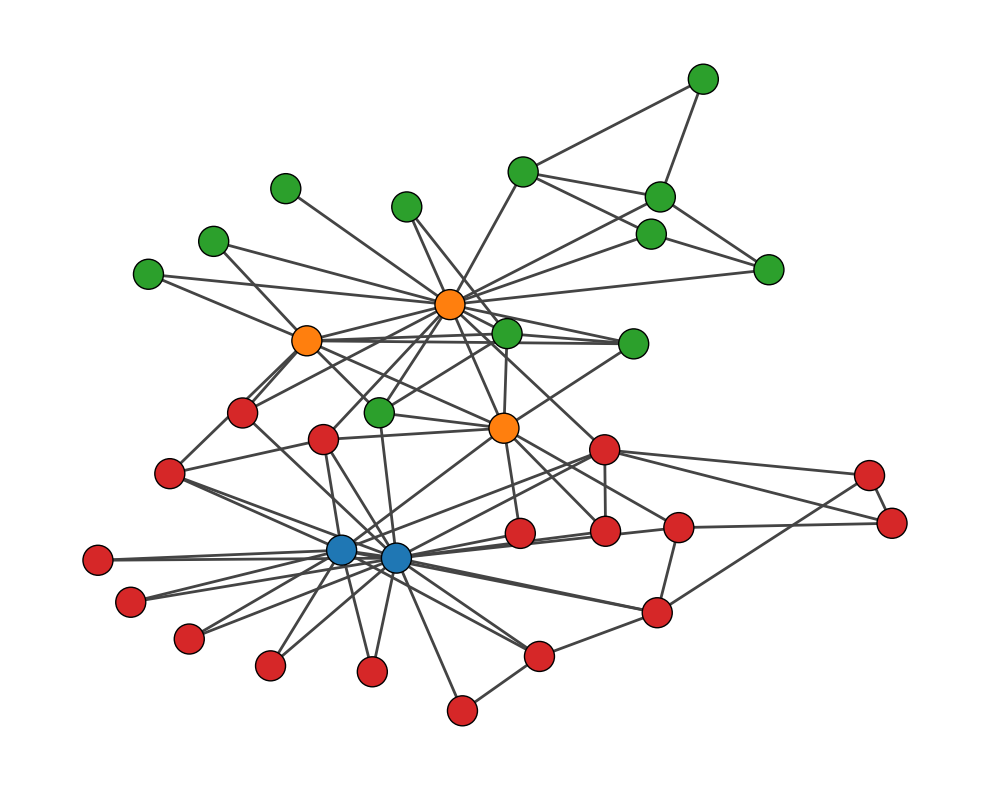

In [4]:
# Convert the block assignments to a list
community_membership = b.get_array()

# The community labels may consist of non-consecutive integers, e.g., 10, 8, 1, 4, ...
# So we reassign the community labels to be 0, 1, 2, ...
community_membership = np.unique(community_membership, return_inverse=True)[1]

# Create a color palette
import matplotlib.pyplot as plt
import seaborn as sns
palette = sns.color_palette().as_hex()
# Plot the graph with nodes colored by their community
fig, ax = plt.subplots(figsize=(10, 8))
igraph.plot(
    g,
    target=ax,
    vertex_color=[palette[i] for i in community_membership],
)
plt.axis('off')
plt.tight_layout()
plt.show()

What we're seeing here isn't a failure at all. In fact, it's twe best partition according to our stochastic block model. The model has discovered something called a **core-periphery structure** {footcite}`borgatti2000models`. Let me break that down:

- Think of a major international airport (the core) and smaller regional airports (the periphery).
- Major international airports have many flights connecting to each other (densely connected).
- Smaller regional airports have fewer connections among themselves (sparsely connected).
- Many regional airports have flights to major hubs (periphery connected to the core).

That's exactly what our model found in this network.

If we look at the adjacency matrix, we would see something that looks like an upside-down "L". This shape is like a signature for core-periphery structures.

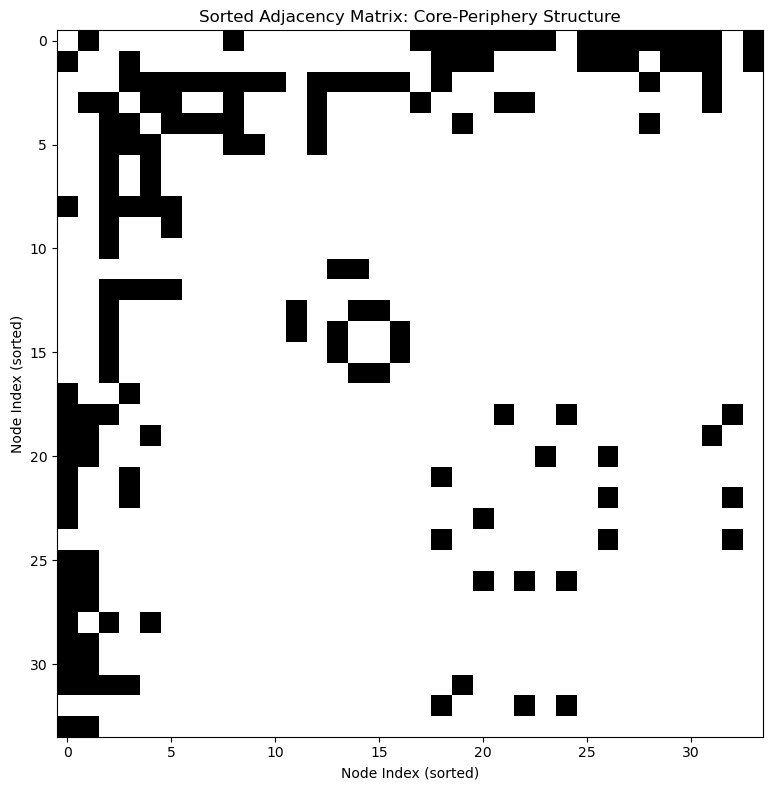

In [5]:
# Convert igraph Graph to adjacency matrix
A = np.array(g.get_adjacency().data)

# Sort nodes based on their community (core first, then periphery)
sorted_indices = np.argsort(community_membership)
A_sorted = A[sorted_indices][:, sorted_indices]

# Plot the sorted adjacency matrix
plt.figure(figsize=(10, 8))
plt.imshow(A_sorted, cmap='binary')
plt.title("Sorted Adjacency Matrix: Core-Periphery Structure")
plt.xlabel("Node Index (sorted)")
plt.ylabel("Node Index (sorted)")

plt.tight_layout()
plt.show()

## Closing remarks

The stochastic block model is a very extensive topic of research, most of which is beyond the scope of this course. But interested readers can refer to the following references for more information.

- {footcite}`karrer2011stochastic` Karrer, Brian, and Mark EJ Newman. "Stochastic blockmodels and community structure in networks." Physical Review E—Statistical, Nonlinear, and Soft Matter Physics 83.1 (2011): 016107.
  - This paper proposes a *degree-corrected* stochastic block model, which can cope with the degree heterogeneity in the network. The paper provides a simple, intuitive explanations of the stochastic block model and its degree-corrected one and is recommended for entry-level readers.
- {footcite}`peixoto2017nonparametric` Peixoto, Tiago P. "Nonparametric Bayesian inference of the microcanonical stochastic block model." Physical Review E 95.1 (2017): 012317.
   - This paper proposes a *nonparameteric* Baysian inference of the stochastic block model. `graph-tool` is implemented and maintained by the author of this paper. The Bayesian inference framework grounds the resolution limit problem on a statistical problem, namely a selection problem of the prior probability of community membership, which is a major departure from the traditional heuristic approaches.
- {footcite}`fortunato2010community,fortunato2016community`: Fortunato, Santo. "Community detection in graphs." Physics reports 486.3-5 (2010): 75-174; Fortunato, Santo, and Darko Hric. "Community detection in networks: A user guide." Physics reports 659 (2016): 1-44.
  - These review papers outline a wide range of community detection methods.


```{footbibliography}
```